In [3]:
from IPython.display import clear_output
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import re
from tqdm import tqdm_notebook as  tqdm 

%pylab inline
pd.set_option('display.max_rows', 7)

Populating the interactive namespace from numpy and matplotlib


# Load data

$L_i$ - полное число людей, ездящих на работу из района $i$ (*source_volumes*)

$Q_j$ - полное число людей, приезжающих на работу в район $j$ (*sink_volumes*)

$(d_{real})_{ij}$ - реальная корреспонденция между районами $i$ и $j$ 

$\sum\limits_j (d_{real})_{ij} = L_i$

$\sum\limits_i(d_{real})_{ij} = W_j$

In [5]:
L = []
W = []

with open('rhs1.txt', "r") as source_file:
    for line in source_file:
        a = re.sub('\s+', ' ', line).strip().split(' ')
        L.append(int(a[1]))
with open('rhs2.txt', "r") as sink_file:
    for line in sink_file:
        a = re.sub('\s+', ' ', line).strip().split(' ')
        W.append(int(a[1]))

In [6]:
L = np.array(L)
W = np.array(W)
L = L.reshape((-1, 1))
W = W.reshape((-1, 1));

In [7]:
costs = []

with open('c.matrix', "r") as cost_file:
    for line in cost_file:
        a = re.sub('\s+', ' ', line).strip().split(' ')
        costs.append(float(a[2]))

In [9]:
costs = np.array(costs)
costs = costs.reshape((L.shape[0], W.shape[0]))
costs.shape

(319, 399)

# Расчеты

**Метод Синхорна: **
$$A^{n+1}_i := \left(\sum_{j=1}^nB_j^nW_jf(c_{ij})\right)^{-1},$$

$$B^{n+1}_j := \left(\sum_{i=1}^nA_i^{n+1}L_if(c_{ij})\right)^{-1}$$

где $t_{ij}$ - среднее время, затрачиваемое для поездки из города $i$ в $j$.


In [10]:
def iterate(A, B, gravity_func, **kwargs):
    A_p = (1 / ((B.T * W.T * gravity_func(**kwargs)).sum(axis = 1, keepdims=True)))
    B_p = (1 / ((A_p * L * gravity_func(**kwargs)).sum(axis = 0, keepdims=True))).T
    return A_p.reshape(A.shape), B_p.reshape(B.shape)

In [11]:
def visualize_dcoef(dA_list, dB_list):
    X = np.linspace(0, len(dA_list), len(dA_list))
    plt.figure(figsize=(14, 6))    
    plt.title("d_coeff / coeff")
    plt.xlabel("iter_num")
    plt.ylabel("d_coeff / coeff")
    plt.plot(X, dA_list, 'b', label='dA/A')
    plt.plot(X, dB_list, 'purple', label='dB/B')
    plt.plot(X, 0*X, "black")
    plt.ylim(top=0.5, bottom=0)
    plt.legend(loc='upper right')

In [24]:
def SinkhornBalance(
        loss_list=None,
        dA_list=None,
        dB_list=None,
        num_of_iterations=100,
        A=np.ones(L.shape),
        B=np.ones(W.shape),
        gravity_func=None,
        visualize=False,
        **kwargs):

    for iter_num in tqdm(range(1, num_of_iterations + 1), desc="iteration number"):
        A_n, B_n = iterate(A, B, gravity_func, **kwargs)
        dA = np.linalg.norm(A - A_n, 2) / np.linalg.norm(A, 2)
        dB = np.linalg.norm(B - B_n, 2) / np.linalg.norm(B, 2)
        
        if dA_list is not None:
            dA_list.append(dA)
            dB_list.append(dB)
        if visualize and dA_list and dB_list:
            visualize_dcoef(dA_list, dB_list)

        if (dA < 1e-4) and (dB < 1e-4):
            print("process converged")
            break
        A, B = A_n, B_n
        if loss_list is not None:
            loss_list.append(
                Loss(real_correspondance,
                     CalculateCorrespondance(A, B, gravity_func, **kwargs)))
    return A, B

In [25]:
def CalculateCorrespondance(A, B, gravity_func=None, around=False, **kwargs):
    if not around:
        return A * L * (B * W).T * gravity_func(**kwargs)
    else:
        return np.around(A * L * (B * W).T * gravity_func(**kwargs), around)

In [15]:
denominator = W.shape[0] * L.shape[0]

In [16]:
def Loss(correspondance, real_correspondance):
    return np.sum((real_correspondance - correspondance) * 
                  (real_correspondance - correspondance)) / (denominator)

In [17]:
def write_one_array_to_file(data_array, file_name):
    with open (file_name, "w") as  file:
        for el in data_array:
            file.write(str(el)+'\n')
            
def write_two_array_to_file(data_array, file_name):
    with open (file_name, "w") as  file:
        file.write("source_volume * sink_volume 2d correspondance matrix\n\n")
        for el in data_array:
            file.write("\t".join(list(map(str, el)))+'\n')

## Экспоненциальная модель

$R(l) =  \left\{
\begin{array}{ll}
\alpha l^{\beta} & \textrm{for } 0\leq l \le \hat l\textrm{,}\\
\nu \ln l & \textrm{for } l \geq \hat l\textrm{.}
\end{array} \right. $

$\hat l$ находим из условия что, $\alpha \hat l^{\beta} = \nu \ln \hat l$. 

Параметры модели взяты из откалиброванной по данным с Москвы расчетам.

In [20]:
def mixed_grav_func(alpha, beta, nu, costs=costs):
    return np.where((alpha * (costs**beta) >= nu * np.log(costs)) &
                    (alpha * beta * (costs**(beta-1)) > nu/costs),
                    1 / costs**nu, np.exp(-alpha * costs**beta))

In [26]:
alpha = 1.51
beta = 0.51 
nu = 2.7
num_iterations = 1000

dA_list = []
dB_list = []
A, B = SinkhornBalance(
    num_of_iterations=num_iterations,
    gravity_func=mixed_grav_func,
    alpha=alpha,
    beta=beta, nu=nu,
    costs=costs,
    dA_list=dA_list,
    dB_list=dB_list)

process converged



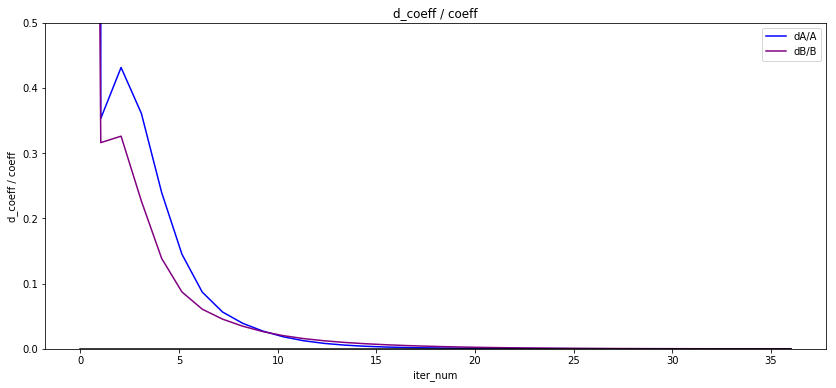

In [27]:
visualize_dcoef(dA_list,dB_list)

In [29]:
correspondance = CalculateCorrespondance(A, B, gravity_func=mixed_grav_func,
                                         alpha=alpha,
                                         beta=beta,
                                         nu=nu,
                                         costs=costs,
                                         around=4)

In [31]:
def write_modeled_corresp_file(costs_file_name, target_file_name, corresp_array):
    new_file_list = []
    with open(costs_file_name, "r") as costs_file:
        for line in costs_file:
            a = re.sub('\s+', ' ', line).strip().split(' ')
            source = int(a[0][:-2])
            sink = int(a[1][:-2])
            cost = float(a[2])
            new_file_list.append([a[0], a[1], cost, 
                                 corresp_array[source-1][sink-1]])
            
    with open(target_file_name, "w") as target_file:
        target_file.write("{:<16}{:<16}{:<16}{:<16}\n\n".
                         format("Source", "Sink", "Cost", "Calculated Correspondance"))
        count_el = 0
        for el in tqdm(new_file_list):
            target_file.write("{:<16}{:<16}{:<16}{:<16}".format(*list(map(str, el))))
            target_file.write("\n")

        
            
write_modeled_corresp_file('c.matrix', "Vladivostok_mixed_grav_model", correspondance)

In [39]:
print(W.reshape(-1)[:15])

[ 367  367  734  367  367  734 1835 1835  367  734  367  367 1835  367
 2202]


In [40]:
print(correspondance.sum(axis=0).reshape(-1)[:15])

[ 366.9982  366.9994  733.9996  366.9995  366.9982  734.0007 1835.0003
 1834.9986  366.9994  733.999   366.9997  366.9999 1834.9991  366.999
 2202.0004]
